# *IMDB Reviews Sentiment Analysis*
---
<br>

## *Overview*
> In this project, IMDB reviews sentiment will be analyzed and trained by 3 machine learning methods including: ***Naive Bayes, Logistic Regression and K-Nearest Neighbor*** classifiers and a ***Recursive Neural Network***. After training and testing phase, Hyperparameter Tuning using ***randomized search with cross-validation*** technique is going to be used to see wether the new models are functioning better or not. and finally, all of the results are going to be compared to each other.<br><br>
***note: The dataset is downloaded from [Here](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)***. 

<br>
<br>

## *Required steps for Machine Learning methods*
> A few steps must be taken in order to format the data properly to train and test the methods. These steps are listed below:
> - Installing and downloading some libraries for preprocessing goals.
- Loading the dataset.
- Preprocessing the dataset.
- Splitting the data to **train** and **test** data.
- Turning the dataset into an array of vectors using ***TF-IDF Vectorizer***.
- Training and testing methods and storing their result in a dataframe.

<br><br>

## *Required steps for Deep Learning method*
> In this project i've written a ***Recursive Neural Network (RNN)*** with embedding layers in it. The steps i took to reformat the data to feed into the network is written below:
> - Training the ***Keras*** tokenizer with the training data.
- Turning the preprocessed dataset into sequences using ***Keras*** library.
- Padding the sequences until they all have equal length.
- fitting the neural network with the data.

<br><br>

## Accuracies

> all methods accuracies are listed below:

| Methods             | Accuracy | Accuracy(Tuned) |
|:------------------- | :------- | :-------------- |
| Naive Bayes         | 85.83    | 85.83           |
| Logistic Regression | 88.90    | 88.90           |
| K-Nearest Neighbor  | 76.42    | 79.41           |
| Neural Network      | 88.54    | NaN             |

<br>

In [40]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime, nltk, spacy, string, re
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, Embedding, BatchNormalization, LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.backend import clear_session

In [3]:
imdb_df = pd.read_csv('IMDB Dataset.csv')
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### ***Analyzing the dataset for imbalances***

in the cell below, i'm checking wether the dataset is equally distributed  or not. As you can see, the dataset is perfectly balanced (50 percent **positive** and 50 percent **negative**) 

Text(0, 0.5, 'Frequency')

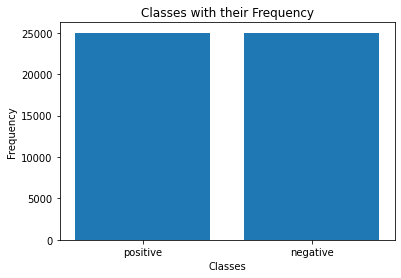

In [4]:
fig, ax = plt.subplots() 
data = imdb_df['sentiment'].value_counts() 

classes = data.index 
frequency = data.values 

ax.bar(classes, frequency) 
ax.set_title('Classes with their Frequency') 
ax.set_xlabel('Classes') 
ax.set_ylabel('Frequency')

### ***Encoding the target labels***

In these cells, the labels **negative** and **positive** are encoded to the numbers 0 and 1.

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
le = LabelEncoder()
imdb_df['sentiment'] = le.fit_transform(imdb_df['sentiment'])

reviews = imdb_df['review'].tolist()
sentiment = imdb_df['sentiment'].tolist()

In [7]:
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### ***Preprocessing***

The preprocessing function consists of 9 stages which are listed below:<br><br>
1. Turning each reviews characters to lowercase characters.
2. Removing \<br /> tags from the reviews.
3. Removing additional spaces and replacing it with one space.
4. Removing punctuations.
5. Splitting each review to its words.
6. Removing stop words.
7. Removing each non-alphabet character in each review.
8. Stemming each word of each review.
9. Joining the words again.

In [11]:
def preprocess(reviews):
    
    puncs = string.punctuation
    sp = spacy.load('en_core_web_sm')
    stp_wrds = sp.Defaults.stop_words
    txt = ''
    stemmer = PorterStemmer()
    result = []

    for each_txt in reviews:
        txt = each_txt.lower()
        txt = re.sub(r'<br />', '', txt)
        txt = re.sub(r'\s{2,}', ' ', txt)
        mytable = txt.maketrans('', '', puncs)
        txt = txt.translate(mytable)
        tokens = txt.split(' ')
        tokens = [word for word in tokens if not word in stp_wrds]
        tokens = [word for word in tokens if  word.isalpha()]
        tokens = [stemmer.stem(each) for each in tokens]
        result.append(' '.join(tokens))

    return result

In [12]:
print(reviews[0])
processed_reviews = preprocess(reviews)
print(processed_reviews[0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [13]:
processed_data_dict = {'Review':processed_reviews, 'Sentiment':sentiment}

imdb_df = pd.DataFrame(processed_data_dict)

In [14]:
imdb_df.head()

,Review,Sentiment
0,review mention watch oz episod youll hook righ...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic there famili littl boy jake think there ...,0
4,petter mattei love time money visual stun film...,1


In [15]:
accuracies_dict = {'Naive Bayes': None, 'Logistic Regression': None, 'KNN': None}
RandomizedSearch_accuracies_dict = {'Naive Bayes': None, 'Logistic Regression': None, 'KNN': None}

### ***Splitting data into train and test data and vectorizing it***
In the cell below, the dataset is being splitted into train and test data with 80%-20% ratio. The parameter ***stratify*** guarantees that the data in both train and test set is being distributed equally, thus 50% of train data have the label ***0*** and the other 50% is ***1***. This condition also applies to the test data.<br><br>
The vectorizing phase is done with ***TF-IDF*** vectorizer. First, i fit the train data to the vectorizer. The vectorizer, does some preprocessing of its own on the texts, then it tokenizes and tries to learn the words from the texts. After, i transform the train data to vectors based on the words the vectorizer has learned. 

In [16]:
X, y = imdb_df['Review'], imdb_df['Sentiment']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 42)

In [17]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)

x_train_vec = vectorizer.transform(x_train)
x_test_vec = vectorizer.transform(x_test)

In [18]:
print(x_train_vec.shape)

(45000, 161581)


### ***fit_model function***
This function, takes a method and the data, fits the data to the model and then reports the precision, recall, f1-score and the accuracy of the model and draws a heatmap of the model if needed. More details about the function is written below:<br><br>

***Parameters***

- **X** is the model.
- **x_train, y_train, x_test, y-test** are the train and test data.
- **acc_dict** is the accuracy dictionary to write the model's accuracy to it for logging porpuses.
- **method** is the name of the model.
- **report** and **draw_heatmap** parameters are optional and set to **True** initially. 

<br><br>

***Returns***<br>
a tuple of the model itself and the accuracy dictionary.


In [19]:
def fit_model(X, x_train, y_train, x_test, y_test, acc_dict, method, report=True, draw_heatmap=True):

    model = X
    model.fit(x_train, y_train)

    pred = model.predict(x_test)
    
    if report:
        print(classification_report(list(y_test), pred))
        acc_dict[method] = accuracy_score(list(y_test), pred)
        
    if draw_heatmap:
        print()
        matrix = confusion_matrix(list(y_test), pred)

        sns.set()
        plt.figure(figsize = (5, 5))

        sns.heatmap(matrix.T,
                    square = True,
                    annot = True,
                    fmt = 'd',
                    cbar = False,
                    linewidths = .9,
                    xticklabels = ['0', '1'],
                    yticklabels = ['0', '1'])

        plt.xlabel('Truth')
        plt.ylabel('Predicted')

    
    return model, acc_dict

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2500
           1       0.86      0.85      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000




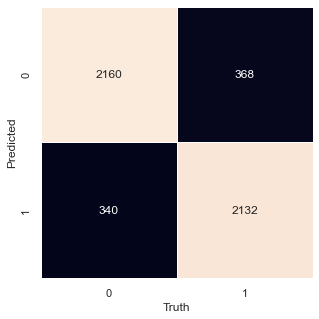

In [20]:
nb, accuracies_dict = fit_model(MultinomialNB(),
        x_train_vec,
        y_train,
        x_test_vec,
        y_test,
        accuracies_dict,
        'Naive Bayes')

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2500
           1       0.88      0.90      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000




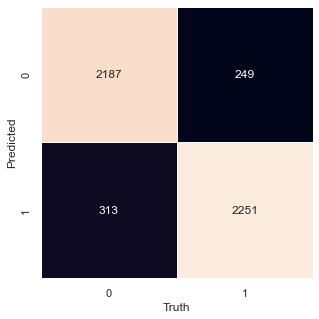

In [21]:
lr, accuracies_dict = fit_model(LogisticRegression(solver='newton-cg'),
        x_train_vec,
        y_train,
        x_test_vec,
        y_test,
        accuracies_dict,
        'Logistic Regression')

### ***Hyperparameter Tuning***
Now, i'm aiming to increase the models accuracy with tuning the parameters with the best values. In this project, i used ***RandomizedSearchCV*** from ***sklearn*** library to do the job. The reason i used RandomizedSearchCV instead of GridSearchCV, is this object takes muc less time despite of GridSearchCV and the results are almost as good as the GridSearchCV object. In the cell below, some parameters with different values are set for different methods we used earlier.

In [ ]:
knn_params = {  
    'n_neighbors': [20, 25, 30, 35, 40],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
}  

nb_params = {  
    'alpha': [0.25, 0.5, 1.0, 1.5, 2.0, 2.5],
    'fit_prior': [True, False]
}  

lr_params = {  
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1.0],
    'class_weight': ['balanced', None], 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [ ]:
def tune_model(model, params, x_train, y_train, cv=5, verbose=2, n_jobs=4):

    model_rs = RandomizedSearchCV(model, params, cv=cv, verbose=verbose, n_jobs=n_jobs)
    model_rs.fit(x_train, y_train)

    return model_rs

In [ ]:
knn_rs = tune_model(knn, knn_params, x_train_vec, y_train)

In [ ]:
knn_rs.best_params_

In [ ]:
rs_knn, RandomizedSearch_accuracies_dict = fit_model(KNeighborsClassifier(30, 'distance', 'auto'),
          x_train_vec,
          y_train,
          x_test_vec,
          y_test,
          RandomizedSearch_accuracies_dict,
          'KNN')

In [ ]:
lr_rs = tune_model(lr, lr_params, x_train_vec, y_train)

In [ ]:
lr_rs.best_params_

In [ ]:
rs_lr, RandomizedSearch_accuracies_dict = fit_model(LogisticRegression(solver='sag',
                                                                       C=1.0,
                                                                       class_weight='balanced',
                                                                       penalty='l2'),
          x_train_vec,
          y_train,
          x_test_vec,
          y_test,
          RandomizedSearch_accuracies_dict,
          'Logistic Regression')

In [ ]:
nb_rs = tune_model(nb, nb_params, x_train_vec, y_train)

In [ ]:
nb_rs.best_params_

In [ ]:
rs_nb, RandomizedSearch_accuracies_dict = fit_model(MultinomialNB(alpha=1.0, fit_prior=False),
          x_train_vec,
          y_train,
          x_test_vec,
          y_test,
          RandomizedSearch_accuracies_dict,
          'Naive Bayes')

In [ ]:
# cmp_df['Tuned Accuracy'] = list(RandomizedSearch_accuracies_dict.values())
# cmp_df.head()

In [28]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
lens = [len(each.split(' ')) for each in processed_reviews]

In [ ]:
print(len([each for each in lens if each >= 300]))
print(len([each for each in lens if each >= 400]))
print(len([each for each in lens if each >= 500]))
print(len([each for each in lens if each >= 600]))
print(len([each for each in lens if each >= 700]))
print(len([each for each in lens if each >= 800]))
print(len([each for each in lens if each >= 900]))
print(len([each for each in lens if each >= 1000]))

### ***Reformatting the Data for Neural Network***
The two cells below, prepares the data for the RNN. The **MAX_WORDS** variable is set to 50000 which is the maximum number of most frequent words we want the neural network to learn and not more. The **MAX_SEQUENCES** variable is set to 600 which is the maximum length of the sequences we want the neural network to learn.<br><br>
After the variables, i used the keras tokenizer to fit the data. The **oov_token** is for the time when the tokenizer sees a word that it does not recognize or the word is not in its dictionary. The **fit_on_texts** function, learns all the words from the texts and stores it with an index attached to each word in a dictionary.<br><br>
After learning the words, i turn each text into a sequence by replacing each word with its index in tokenizer's vocabulary with **text_to_sequences** function. Then, make all the sequences to have equal length by adding 0 to the sequences until all sequences have the same length as the sequence with the maximum length. This is done by **pad_sequences** function.<br> The **padding** parameter is set to 'post' which means it adds 0 at the end of the sequences. The **truncating** parameter is set to 'post' which means that it removes all the elements **after** the 600th(the **MAX_SEQUENCES** variable) element in all the sequences if they are longer than 600 elements. Here's an example of these steps:<br><br>
![example](https://drive.google.com/uc?export=view&id=1qHMw8ftgHhJGwdAL8_v_cnAT6bwqyKE3)

In [23]:
MAX_WORDS = 50000
MAX_SEQUENCES = 600

keras_tokenizer = Tokenizer(num_words = MAX_WORDS, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(x_train)

word_index = keras_tokenizer.word_index
vocab_size = len(word_index)


train_sequences = keras_tokenizer.texts_to_sequences(x_train)
train_sequences_padded = pad_sequences(train_sequences, maxlen = MAX_SEQUENCES, padding='post', truncating='post')

test_sequences = keras_tokenizer.texts_to_sequences(x_test)
test_sequences_padded = pad_sequences(test_sequences, maxlen = MAX_SEQUENCES, padding='post', truncating='post')

In [24]:
train_sequences_padded = np.array(train_sequences_padded)
target_train = np.array(y_train)

test_sequences_padded = np.array(test_sequences_padded)
target_test = np.array(y_test)

### ***Neural Network Training***

The function below, creates and trains a recursive neural network. The neural network i've created consists of these layers:<br>

1. An ***embedding*** layer to make a vector of each seq to x-dimensions.
2. An ***GlobalAveragePooling1D*** layer to get an average of each vector.
3. Two hidden **Dense** layers with the **'relu'** activation function.
4. A **Dense** output layer with 1 neuron and with **'sigmoid'** activation function, because the project is binary classification.

<br>

#### ***The Embedding Layer***
This layer, puts each element of each sequence in a ***X***-dimensions space ***(x is 64 by default in this function)***. Thus, the shape of the embedding layer's input will bee 600 \* 64.<br><br>

#### ***The GlobalAveragePooling1D layer***
This layer, gets an average of each sequences elements and makes each sequence, one dimensial. The image below, shows how these two layers work.<br><br>
***Note: GAP stands for Global Average Pooling.***<br><br>
![example](https://drive.google.com/uc?export=view&id=1kuu9RAdXro3cZYyI1pu0IW2i9zXX2MSp)

In [77]:
def make_NN(x_train, y_train, x_test, y_test, vocab_size, embedding_dim=27, epochs=10, plot=True):

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=MAX_SEQUENCES))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.007))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    time = datetime.datetime.today().strftime('%Y-%m-%d')
    model_path = f'models/model {time}/model.h5'
    opt = tf.keras.optimizers.Adam(learning_rate=2e-5, decay=9e-6)
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', mode='max', save_best_only=True)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    print('\n')
    
    history = model.fit(x_train, y_train,
                    epochs=epochs,
                    verbose='auto',
                    validation_split=0.1,
                    batch_size=128,
                    callbacks=[checkpoint])
    
    if plot:
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plot_graphs(history, 'accuracy')
        plt.ylim(None, 1)
        plt.subplot(1, 2, 2)
        plot_graphs(history, 'loss')
        plt.ylim(0, None)

    predicted_texts = model.predict(x_test)

    loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))

    return predicted_texts

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 27)           4363605   
                                                                 
 global_average_pooling1d (G  (None, 27)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2

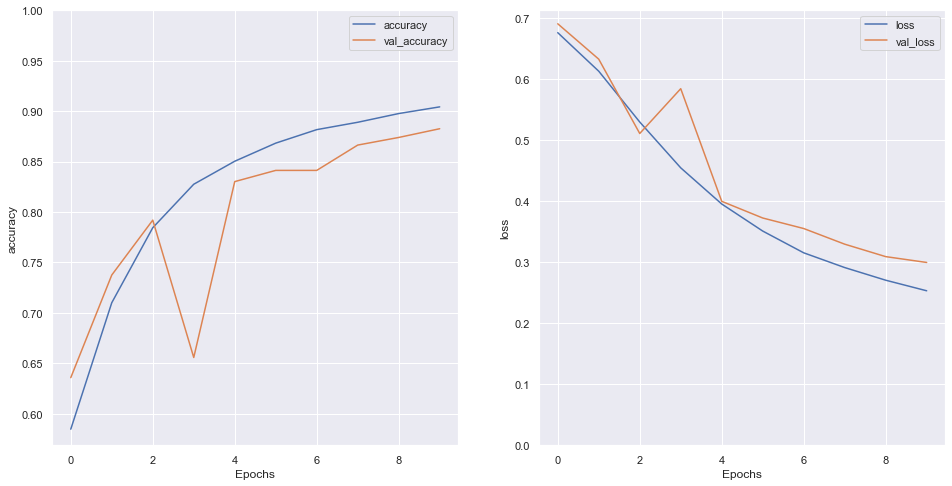

In [78]:
NN_pred = make_NN(train_sequences_padded, target_train, test_sequences_padded, target_test, vocab_size=vocab_size)

In [76]:
clear_session()

In [38]:
print(NN_pred[0])
preds = [round(each[0]) for each in NN_pred]
print(preds[:10])

[0.8000922]
[1, 1, 0, 1, 0, 0, 0, 1, 0, 1]


Text(25.1, 0.5, 'Predicted')

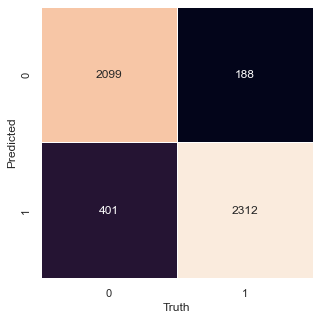

In [39]:
matrix = confusion_matrix(list(y_test), preds)

sns.set()
plt.figure(figsize = (5, 5))

sns.heatmap(matrix.T,
            square = True,
            annot = True,
            fmt = 'd',
            cbar = False,
            linewidths = .9,
            xticklabels = ['0', '1'],
            yticklabels = ['0', '1'])

plt.xlabel('Truth')
plt.ylabel('Predicted')